In [1]:
import numpy as np
import tensorflow as tf

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [55]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Activation, MaxPool2D, UpSampling2D, GroupNormalization, \
                                    Add, Multiply
from tensorflow.keras.models import Model

In [8]:
def conv(x, filters=8, activation="swish"):
    for i in range(2):
        x = Conv2D(filters, (3,3), padding='same')(x)
        x = GroupNormalization(groups=-1)(x) # InstanceNorm
        x = Activation(activation)(x)
        
    return x

In [9]:
def unet(filters=8, layers=4, input_shape=(256,256,1), activation='swish'):
    to_concat = []
    
    model_in = Input(input_shape)
    x = model_in
    
    # Encoder
    for i in range(layers):
        x = conv(x, filters*2**i, activation)
        to_concat.append(x)
        x = MaxPool2D()(x)
    
    # Latent
    x = Conv2D(filters*2**layers, (3,3), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)  # InstanceNorm
    x = Activation(activation)(x)
    
    # Decoder
    for i in range(layers):
        x = UpSampling2D()(x)
        x = Concatenate()([x, to_concat.pop()])
        x = conv(x, filters*2**(layers-i-1), activation)
    
    x = Conv2D(1, (1,1), padding='same')(x)
    model_out = Activation("sigmoid")(x)
    
    return Model(model_in, model_out)

In [10]:
m = unet()

In [60]:
def nestedUnet(nests=4, filters=1, forward_input=True, operation="multiply", input_shape=(256, 256, 1)):
    x = Input(input_shape)
    
    m0 = unet(filters, input_shape=input_shape)(x)
    
    if nests > 1:
        tmp = m0
        
        for i in range(nests-1):
            if forward_input:
                if operation == 'add':
                    tmp = Add()([x, tmp])
                    
                elif operation == 'multiply':
                    tmp = Multiply()([x, tmp])
                    
                else:
                    tmp = Concatenate(axis=3)([x, tmp])
                
            tmp = unet(filters, input_shape=tmp.shape[1:])(tmp)

        return Model(x, tmp)        
        
    else:
        return Model(x, m0)
    
y = nestedUnet(4, 1)

In [61]:
y.summary()

Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_87 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_81 (Functional)          (None, 256, 256, 1)  5594        ['input_87[0][0]']               
                                                                                                  
 multiply (Multiply)            (None, 256, 256, 1)  0           ['input_87[0][0]',               
                                                                  'model_81[0][0]']               
                                                                                           

In [30]:
X = np.zeros((128, 256, 256, 1), dtype=np.float32)

X[:, 100:140, 80:120] = 1

In [31]:
import matplotlib.pyplot as plt

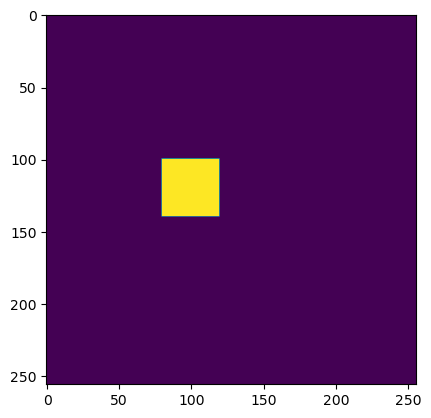

In [32]:
plt.imshow(X.sum((0,3)))

In [52]:
y.compile("adam", "mse")

In [53]:
h = y.fit(X, X, batch_size=4, epochs=10)

Epoch 1/10
32/32 [==============================] - 42s 820ms/step - loss: 0.2475
Epoch 2/10
 5/32 [===>..........................] - ETA: 23s - loss: 0.2308

KeyboardInterrupt: 

4/4 [==============================] - 7s 1s/step


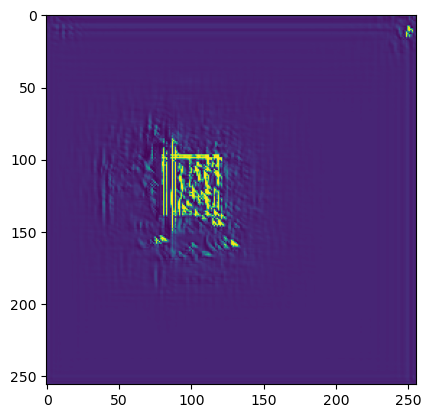

In [54]:
plt.imshow(y.predict(X).sum((0,3)))